In [4]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import re
from string import punctuation,digits,ascii_letters
import pickle
from tensorflow.keras.utils import plot_model

In [5]:
dataset = pd.read_csv('../Dataset_English_Hindi.csv')
dataset = dataset.sample(frac=1)
dataset = dataset.reset_index(drop=True).dropna()
dataset['Hindi'] = dataset['Hindi'].apply(lambda x: x.lower().strip())
dataset['English'] = dataset['English'].apply(lambda x: x.lower().strip())
# Strip punctuation
exclude_chars_hindi = set(punctuation+digits+ascii_letters+'[२३०८१५७९४६]')
exclude_chars_english = set(punctuation+digits)
dataset['Hindi'] = dataset['Hindi'].apply(lambda x: ''.join([ch for ch in x if ch not in exclude_chars_hindi]))
dataset['English'] = dataset['English'].apply(lambda x: ''.join([ch for ch in x if ch not in exclude_chars_english]))
dataset['len_english'] = dataset['English'].apply(lambda x: len(list(x)))
dataset['len_hindi'] = dataset['Hindi'].apply(lambda x: len(list(x)))
indexes = dataset[ ( dataset['len_english']>64 ) | ( dataset['len_hindi']>64 ) ].index
dataset.drop(indexes,inplace=True)
dataset['Hindi'] = dataset['Hindi'].apply(lambda x: 'START__ ' + x + ' __END')

In [6]:
dataset['English'] = dataset['English'].apply(lambda x: ''.join([ch for ch in x if ch!='"']))

In [7]:
# Making the vocabularies
english_vocab_dict = dict()
hindi_vocab_dict = dict()
english_vocab_dict['[UNK]'] = 0
hindi_vocab_dict['[UNK]'] = 0

for sentence in dataset['English']:
    for word in re.split('\s+',sentence):
        if(word not in english_vocab_dict.keys()):
            english_vocab_dict[word] = 1
        else:
            english_vocab_dict[word]+=1

for sentence in dataset['Hindi']:
    for word in re.split('\s+',sentence):
        if(word not in hindi_vocab_dict.keys()):
            hindi_vocab_dict[word] = 1
        else:
            hindi_vocab_dict[word]+=1

english_vocab_dict = {word:freq for word,freq in sorted(english_vocab_dict.items(),key=lambda pair: pair[1],reverse=True)}
hindi_vocab_dict = {word:freq for word,freq in sorted(hindi_vocab_dict.items(),key=lambda pair: pair[1],reverse=True)}

# for word,freq in english_vocab_dict.copy().items():
#     if(freq<2 and word != '[UNK]'):
#         english_vocab_dict.pop(word)
#         english_vocab_dict['[UNK]']+=1

# for word,freq in hindi_vocab_dict.copy().items():
#     if(freq<2 and word != '[UNK]'):
#         hindi_vocab_dict.pop(word)
#         hindi_vocab_dict['[UNK]']+=1

english_vocab_keys = list(english_vocab_dict.keys())
hindi_vocab_keys = list(hindi_vocab_dict.keys())

In [8]:
len(dataset)

63365

In [9]:
e_wtoi = dict([(word,i+1) for i,word in enumerate(english_vocab_dict)])
h_wtoi = dict([(word,i+1) for i,word in enumerate(hindi_vocab_dict)])

e_itow = dict([(i+1,word) for i,word in enumerate(english_vocab_dict)])
h_itow = dict([(i+1,word) for i,word in enumerate(hindi_vocab_dict)])

In [10]:
def mapToVocab(vector,lang):
    vector = tf.squeeze(vector)
    if lang == 'english':
        vocab = e_itow
    else:
        vocab = h_itow
    translation = ""
    for i in vector.numpy():
        if(i == 0):
            break
        translation+= ' '+vocab[i]
    return translation

In [11]:
def make_dataset(dataset, english_vocab, hindi_vocab, batch_size, len_tokens):
    dataset = dataset[:int(len(dataset)/batch_size)*batch_size]
    english_dataset = dataset['English']
    hindi_dataset = dataset['Hindi']
    encoder_input = np.zeros(shape=(1,len_tokens))
    decoder_input = np.zeros(shape=(1,len_tokens))
    decoder_output = np.zeros(shape=(1,len_tokens))
    for i,(eng_sentence,hin_sentence) in enumerate(zip(english_dataset,hindi_dataset)):
        encoder_input_iter = np.zeros(shape=(1,len_tokens))
        decoder_input_iter = np.zeros(shape=(1,len_tokens))
        decoder_output_iter = np.zeros(shape=(1,len_tokens))
        for j,word in enumerate(re.split('\s+',eng_sentence)):
            try:
                encoder_input_iter[0 , j] = english_vocab[word]
            except:
                encoder_input_iter[0 , j] = english_vocab["[UNK]"]
        for j,word in enumerate(re.split('\s+',hin_sentence)):
            try:
                decoder_input_iter[0 , j] = hindi_vocab[word] if word != '__END' else 0
            except:
                decoder_input_iter[0 , j] = hindi_vocab["[UNK]"]
        for j,word in enumerate(re.split('\s+',hin_sentence)):
            if(j==0):
                continue
            try:
                decoder_output_iter[0 , j-1] = hindi_vocab[word]
            except:
                decoder_output_iter[0 , j-1] = hindi_vocab["[UNK]"]
        encoder_input = np.vstack((encoder_input,encoder_input_iter))
        decoder_input = np.vstack((decoder_input,decoder_input_iter))
        decoder_output = np.vstack((decoder_output,decoder_output_iter))
        print(f"{i+1}/{len(english_dataset)}",end='\r')
    # encoder_input = encoder_input[1:].reshape((-1,batch_size,len_tokens))
    # decoder_output = decoder_output[1:].reshape((-1,batch_size,len_tokens))
    # decoder_input = decoder_input[1:].reshape((-1,batch_size,len_tokens))
    return encoder_input[1:],decoder_input[1:],decoder_output[1:]

In [12]:
with open('../dataset_vec.pickle','rb') as f:
    data_vectorised = pickle.load(f)

In [13]:
# The encoder for training
encoder_input = tf.keras.layers.Input(shape=(64,))
encoder_emb = tf.keras.layers.Embedding(input_dim=len(english_vocab_keys),output_dim=300,mask_zero=True,name='encoder_emb')(encoder_input)
_,state_h,state_c = tf.keras.layers.LSTM(units=300,return_state=True,name='encoder_LSTM')(encoder_emb)
encoder_states = [state_h,state_c]

# The decoder for training
decoder_input = tf.keras.layers.Input(shape=(64,))
decoder_emb = tf.keras.layers.Embedding(input_dim=len(hindi_vocab_keys),output_dim=300,mask_zero=True,name='decoder_emb')(decoder_input)
dec_lstm,_,_ = tf.keras.layers.LSTM(units=300,return_state=True,return_sequences=True,name='decoder_LSTM')(decoder_emb,initial_state=encoder_states)
dec_dense = tf.keras.layers.Dense(units=len(hindi_vocab_keys),activation='softmax',name='output_dense')(dec_lstm)

training_model = tf.keras.Model(inputs=[encoder_input,decoder_input],outputs=[dec_dense])

In [14]:
# training_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')
# history = training_model.fit(x=[encoder_inputs,decoder_inputs],y=decoder_labels,batch_size=32,epochs=1)

In [15]:
training_model.load_weights('TrainingModelWeights10Epochs.h5')

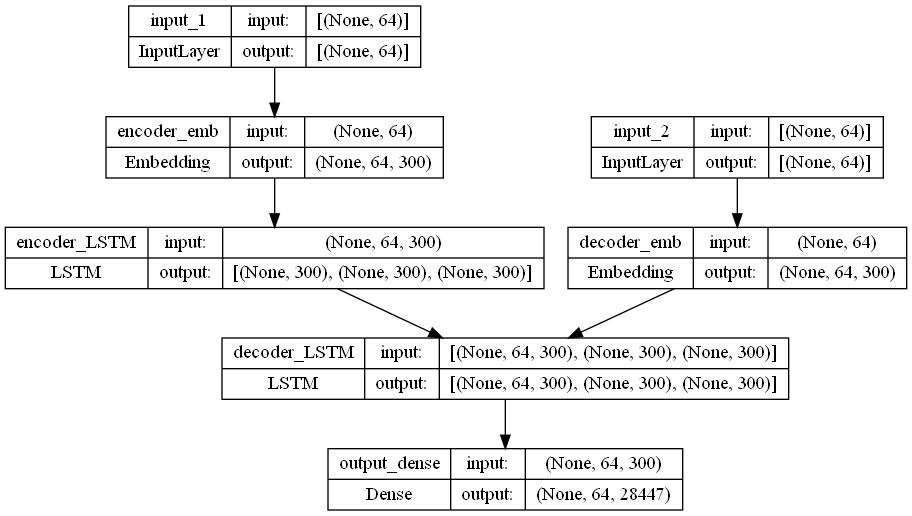

In [16]:
plot_model(training_model,show_shapes=True)

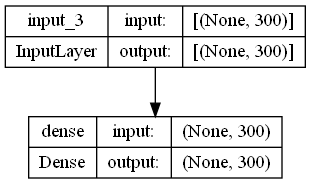

In [17]:
inp = tf.keras.layers.Input(shape=(300,))
dense = tf.keras.layers.Dense(units=300)(inp)
m = tf.keras.Model(inputs=inp,outputs=dense)
plot_model(m,show_shapes=True)

In [18]:
encoder_model = tf.keras.Model(inputs=encoder_input,outputs=[encoder_states])

decoder_input_2 = tf.keras.layers.Input(shape=(None,))
decoder_hidden_state = tf.keras.layers.Input(shape=(300,))
decoder_cell_state = tf.keras.layers.Input(shape=(300,))

decoder_input_states = [decoder_hidden_state,decoder_cell_state]

emb_layer = training_model.get_layer('decoder_emb')
embeddings = emb_layer(decoder_input_2)

dec_lstm = training_model.get_layer('decoder_LSTM')
lstm_output,hidden_state,cell_state = dec_lstm(embeddings,initial_state=[decoder_hidden_state, decoder_cell_state])
output_states = [hidden_state,cell_state]

dec_dense = training_model.get_layer('output_dense')
dense_outputs = dec_dense(lstm_output)

decoder_model = tf.keras.Model(inputs=[decoder_input_2, decoder_input_states],outputs=[dense_outputs,output_states])

In [19]:
def translate(english_sentence):
    english_sentence = english_sentence.lower()
    translation = ''
    sentence_vector = np.zeros(shape=(64,))
    for j,word in enumerate(re.split('\s+',english_sentence)):
        try:
            sentence_vector[j] = e_wtoi[word]
        except:
            sentence_vector[j] = e_wtoi['[UNK]']
    sentence_vector = sentence_vector.reshape((1,64))
    
    states = encoder_model.predict(sentence_vector)
    sampled_hindi = np.zeros((1,1))
    sampled_hindi[0 , 0] = h_wtoi['START__']
    stop = False
    i = 0
    while not stop:
        i+=1
        new_word, output_states = decoder_model.predict([sampled_hindi,states])
        word = np.argmax(new_word,axis=-1)
        word = np.squeeze(word)
        word = word.item()
        translation += h_itow[word] + ' '
        if (h_itow[word] == '__END' or i>=64):
            stop = True
        sampled_hindi[0 , 0] =  word
        states = output_states

    translation = ' '.join(translation.strip().split(' ')[:-1])
    return translation
translate('how are you doing')

1/1 [==============================] - 0s 18ms/step


'तुम कैसे हो'